This notebook uses [PyTorch](https://pytorch.org/), which is a library that can automatically differentiate functions and is commonly used to implement neural networks. Because of its capability to automatically differentiate functions, the formula for the gradient does not need to be manually derived -- this comes especially handy when working with neural networks, whose gradient formula can be quite complicated, especially for complex architectures. 

We recommend going over the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/intro.html) and then the starter code below. For any new functions that you come across, you can look up the documentation [here](https://pytorch.org/docs/stable/index.html). 

We recommend running this notebook on Google Colab to avoid having to install PyTorch and to take advantage of GPUs, which make training faster.

## Load packages

In [1]:
# load packages
# make sure to install the pacakge "tqdm" for the progress bar when training.
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import imageio
import matplotlib.image as mpimg
from scipy import ndimage

from sklearn.manifold import TSNE

path_prefix = ""

If running on Google Colab, you need to upload the file `autoencoder_starter.py`. To do so, you need to click on the folder icon on the left side of the page, which brings up a panel that would allow you to upload files. Note however uploading the file this way has a downside in that if your Python runtime times out or is otherwise restarted, the file will be erased and you will need to re-upload. 

If you would like to avoid this, you can create a directory named `CMPT_726Fall2021_A3` in your Google Drive and upload `autoencoder_starter.py` to that directory. Then execute the following block of code to mount your Google Drive. 

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
trainTransform  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,))])
trainset = torchvision.datasets.FashionMNIST(root="C:\\Users\\chara\\OneDrive\\Desktop\\ML Course\\Assignment 3\\data",  train=True,download=True, transform=transform)

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A3"

# import sys
# sys.path.insert(1, path_prefix)

## Define your architecture here.

The `Autoencoder` class has several important functions unimplemented. You are required to implement the two sub-classes of `Encoder` and `Decoder`, i.e, the architecture and forward function of the encoder and decoder.


In [4]:
class Autoencoder(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(Autoencoder,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size):
                super(Encoder, self).__init__()
                # needs your implementation
                in_features = 28 * 28
                out_features = output_size
                self.encoder = nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=out_features)
                )

            def forward(self, x):
                # needs your implementation
                input_dimension = x.shape
                x = x.reshape(-1, input_dimension[2] * input_dimension[3])
                x = self.encoder(x)
                return x

        class Decoder(nn.Module):
            def __init__(self, input_size):
                super(Decoder, self).__init__()
                # needs your implementation
                in_features = input_size
                out_features = 28 * 28
                self.decoder = nn.Sequential(
                    nn.Linear(in_features=in_features, out_features=out_features),
                    nn.Tanh()
                )

            def forward(self, z):
                # needs your implementation
                z = self.decoder(z)
                return z.reshape(-1, 1, 28, 28)

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    # def add_noise(self, x, noise_type):
    #     if noise_type=='Gaussian':
    #         # return (x with Gaussian noise)
    #     elif noise_type=='Dropout':
    #         return (x with Dropout noise)

    # Implement this function for the VAE model
    # def reparameterise(self, mu, logvar):
    #     if self.training:
    #         # return reparametrized mu
    #     else:
    #         return mu

    def forward(self,x):
        # This function should be modified for the DAE and VAE
        x = self.encoder(x)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x

In [5]:
class VAE(nn.Module):

    def __init__(self,dim_latent_representation=2):

        super(VAE,self).__init__()

        class Encoder(nn.Module):
            def __init__(self, output_size):
                super(Encoder, self).__init__()
                # needs your implementation
                in_features = 28 * 28
                out_features = output_size
                self.linear_layer = nn.Linear(in_features=in_features, out_features=out_features)
                self.mean_layer = nn.Linear(in_features=out_features, out_features=out_features)
                self.var_layer = nn.Linear(in_features=out_features, out_features=out_features)

            def forward(self, x):
                # needs your implementation
                input_dimension = x.shape
                x = x.reshape(-1, input_dimension[2] * input_dimension[3])
                x = self.linear_layer(x)
                mean = self.mean_layer(x)
                var = self.var_layer(x)
                return mean, var

        class Decoder(nn.Module):
            def __init__(self, input_size=2):
                super(Decoder, self).__init__()
                # needs your implementation
                in_features = input_size
                out_features = 28 * 28
                self.linear_layer = nn.Linear(in_features=in_features, out_features=out_features)
                self.activation_layer = nn.Tanh()

            def forward(self, z):
                # needs your implementation
                input_dimension = z.shape
                z = self.linear_layer(z)
                z = self.activation_layer(z)
                return z.reshape(-1, 1, 28, 28)

        self.encoder = Encoder(output_size=dim_latent_representation)
        self.decoder = Decoder(input_size=dim_latent_representation)

    # Implement this function for the DAE model
    # def add_noise(self, x, noise_type):
    #     if noise_type=='Gaussian':
    #         # return (x with Gaussian noise)
    #     elif noise_type=='Dropout':
    #         return (x with Dropout noise)

    # Implement this function for the VAE model
    def reparameterise(self, mu, logvar):
        if self.training:
            # return reparametrized mu
            std = torch.exp(0.5*logvar)
            parameters = torch.randn_like(std)
            return mu + std*parameters
        else:
            return mu

    def forward(self,x):
        # This function should be modified for the DAE and VAE
        mean, var = self.encoder(x)
        x = self.reparameterise(mean, var)
        x = self.decoder(x)
        # for the VAE forward function should also return mu and logvar
        return x

## Training the Model

The training loop is provided by the `Autoencoder_Trainer` class from `autoencoder_starter.py`.

In [6]:
from autoencoder_starter import Autoencoder_Trainer

LEARNING_RATE = 1e-3
EPOCH_NUMBER= 10 # the number of epochs and learning rate can be tuned.

autoencoder = Autoencoder(dim_latent_representation=30)
trainer = Autoencoder_Trainer(autoencoder_model=autoencoder,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        trainer.train(epoch)
        trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

100%|██████████| 1875/1875 [00:07<00:00, 239.85it/s]


====> Epoch: 1 Average loss: 0.4799


100%|██████████| 313/313 [00:02<00:00, 154.98it/s]


====> Val set loss (reconstruction error) : 0.4318


100%|██████████| 1875/1875 [00:05<00:00, 334.70it/s]


====> Epoch: 2 Average loss: 0.4166


100%|██████████| 313/313 [00:01<00:00, 161.53it/s]


====> Val set loss (reconstruction error) : 0.4213


100%|██████████| 1875/1875 [00:06<00:00, 312.03it/s]


====> Epoch: 3 Average loss: 0.4127


100%|██████████| 313/313 [00:02<00:00, 150.86it/s]


====> Val set loss (reconstruction error) : 0.4203


100%|██████████| 1875/1875 [00:05<00:00, 322.96it/s]


====> Epoch: 4 Average loss: 0.4118


100%|██████████| 313/313 [00:02<00:00, 124.34it/s]


====> Val set loss (reconstruction error) : 0.4197


100%|██████████| 1875/1875 [00:06<00:00, 295.61it/s]


====> Epoch: 5 Average loss: 0.4112


100%|██████████| 313/313 [00:02<00:00, 127.92it/s]


====> Val set loss (reconstruction error) : 0.4193


100%|██████████| 1875/1875 [00:06<00:00, 305.79it/s]


====> Epoch: 6 Average loss: 0.4107


100%|██████████| 313/313 [00:02<00:00, 122.58it/s]


====> Val set loss (reconstruction error) : 0.4188


100%|██████████| 1875/1875 [00:06<00:00, 301.44it/s]


====> Epoch: 7 Average loss: 0.4102


100%|██████████| 313/313 [00:02<00:00, 123.92it/s]


====> Val set loss (reconstruction error) : 0.4187


100%|██████████| 1875/1875 [00:06<00:00, 298.68it/s]


====> Epoch: 8 Average loss: 0.4099


100%|██████████| 313/313 [00:02<00:00, 126.10it/s]


====> Val set loss (reconstruction error) : 0.4188


100%|██████████| 1875/1875 [00:06<00:00, 296.20it/s]


====> Epoch: 9 Average loss: 0.4097


100%|██████████| 313/313 [00:02<00:00, 119.50it/s]


====> Val set loss (reconstruction error) : 0.4188


100%|██████████| 1875/1875 [00:06<00:00, 292.28it/s]


====> Epoch: 10 Average loss: 0.4096


100%|██████████| 313/313 [00:02<00:00, 117.42it/s]

====> Val set loss (reconstruction error) : 0.4187


In [7]:
from VAE_starter import VAE_Trainer

LEARNING_RATE = 5e-4
EPOCH_NUMBER= 20 # the number of epochs and learning rate can be tuned.

VAE_model = VAE(dim_latent_representation=30)
vae_trainer = VAE_Trainer(VAE_model=VAE_model,learning_rate=LEARNING_RATE,path_prefix=path_prefix)

try:
    for epoch in range(1, EPOCH_NUMBER + 1):
        vae_trainer.train(epoch)
        vae_trainer.validate(epoch)
except (KeyboardInterrupt, SystemExit):
        print("Manual Interruption")

  0%|          | 0/1875 [00:00<?, ?it/s]c:\Users\chara\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\functional.py:2904: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(
100%|██████████| 1875/1875 [00:09<00:00, 189.76it/s]


====> Epoch: 1 Average loss: 0.5758


100%|██████████| 313/313 [00:02<00:00, 125.86it/s]


====> Val set loss (reconstruction error) : 0.5041


100%|██████████| 1875/1875 [00:11<00:00, 166.65it/s]


====> Epoch: 2 Average loss: 0.4617


100%|██████████| 313/313 [00:03<00:00, 102.17it/s]


====> Val set loss (reconstruction error) : 0.4401


100%|██████████| 1875/1875 [00:10<00:00, 182.58it/s]


====> Epoch: 3 Average loss: 0.4195


100%|██████████| 313/313 [00:02<00:00, 115.40it/s]


====> Val set loss (reconstruction error) : 0.4153


100%|██████████| 1875/1875 [00:10<00:00, 186.84it/s]


====> Epoch: 4 Average loss: 0.4012


100%|██████████| 313/313 [00:02<00:00, 111.02it/s]


====> Val set loss (reconstruction error) : 0.4028


100%|██████████| 1875/1875 [00:09<00:00, 190.01it/s]


====> Epoch: 5 Average loss: 0.3920


100%|██████████| 313/313 [00:02<00:00, 118.10it/s]


====> Val set loss (reconstruction error) : 0.3960


100%|██████████| 1875/1875 [00:09<00:00, 196.54it/s]


====> Epoch: 6 Average loss: 0.3871


100%|██████████| 313/313 [00:02<00:00, 115.69it/s]


====> Val set loss (reconstruction error) : 0.3923


100%|██████████| 1875/1875 [00:09<00:00, 194.91it/s]


====> Epoch: 7 Average loss: 0.3845


100%|██████████| 313/313 [00:02<00:00, 111.96it/s]


====> Val set loss (reconstruction error) : 0.3905


100%|██████████| 1875/1875 [00:09<00:00, 196.54it/s]


====> Epoch: 8 Average loss: 0.3829


100%|██████████| 313/313 [00:02<00:00, 116.20it/s]


====> Val set loss (reconstruction error) : 0.3891


100%|██████████| 1875/1875 [00:09<00:00, 194.71it/s]


====> Epoch: 9 Average loss: 0.3815


100%|██████████| 313/313 [00:02<00:00, 116.28it/s]


====> Val set loss (reconstruction error) : 0.3876


100%|██████████| 1875/1875 [00:09<00:00, 194.10it/s]


====> Epoch: 10 Average loss: 0.3805


100%|██████████| 313/313 [00:02<00:00, 116.48it/s]


====> Val set loss (reconstruction error) : 0.3868


100%|██████████| 1875/1875 [00:09<00:00, 195.50it/s]


====> Epoch: 11 Average loss: 0.3798


100%|██████████| 313/313 [00:02<00:00, 116.38it/s]


====> Val set loss (reconstruction error) : 0.3863


100%|██████████| 1875/1875 [00:09<00:00, 195.62it/s]


====> Epoch: 12 Average loss: 0.3791


100%|██████████| 313/313 [00:02<00:00, 115.08it/s]


====> Val set loss (reconstruction error) : 0.3857


100%|██████████| 1875/1875 [00:09<00:00, 200.13it/s]


====> Epoch: 13 Average loss: 0.3786


100%|██████████| 313/313 [00:02<00:00, 114.11it/s]


====> Val set loss (reconstruction error) : 0.3853


100%|██████████| 1875/1875 [00:09<00:00, 202.12it/s]


====> Epoch: 14 Average loss: 0.3782


100%|██████████| 313/313 [00:02<00:00, 113.15it/s]


====> Val set loss (reconstruction error) : 0.3850


100%|██████████| 1875/1875 [00:09<00:00, 197.28it/s]


====> Epoch: 15 Average loss: 0.3778


100%|██████████| 313/313 [00:02<00:00, 115.67it/s]


====> Val set loss (reconstruction error) : 0.3848


100%|██████████| 1875/1875 [00:09<00:00, 190.66it/s]


====> Epoch: 16 Average loss: 0.3775


100%|██████████| 313/313 [00:02<00:00, 116.12it/s]


====> Val set loss (reconstruction error) : 0.3846


100%|██████████| 1875/1875 [00:09<00:00, 199.90it/s]


====> Epoch: 17 Average loss: 0.3772


100%|██████████| 313/313 [00:02<00:00, 117.29it/s]


====> Val set loss (reconstruction error) : 0.3845


100%|██████████| 1875/1875 [00:09<00:00, 197.75it/s]


====> Epoch: 18 Average loss: 0.3770


100%|██████████| 313/313 [00:02<00:00, 116.80it/s]


====> Val set loss (reconstruction error) : 0.3844


100%|██████████| 1875/1875 [00:09<00:00, 199.03it/s]


====> Epoch: 19 Average loss: 0.3768


100%|██████████| 313/313 [00:02<00:00, 116.48it/s]


====> Val set loss (reconstruction error) : 0.3843


100%|██████████| 1875/1875 [00:09<00:00, 199.09it/s]


====> Epoch: 20 Average loss: 0.3765


100%|██████████| 313/313 [00:02<00:00, 115.25it/s]

====> Val set loss (reconstruction error) : 0.3839


If in the above cell, you find that the download of the dataset is unsuccessful because the server is down, you can also download the data from Canvas and put the data in the same directory of this notebook and `autoencoder_starter.py`. If you are running this notebook on Google Colab, you can create a directory called `CMPT_726Fall2021_A3` in your Google Drive and put the data directory you downloaded from Canvas inside. Then if you haven't mounted your Google Drive earlier using the block of code above, mount Google Drive by executing the following block of code.

In [8]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# path_prefix = "/content/gdrive/MyDrive/CMPT_726Fall2021_A3"

## Visualizing 2D Bottleneck Feature Representations

We can visualize the 2D bottleneck representations of data points and their ground truth class labels with a scatter plot.

The `scatter_plot` function takes the following arguments:
* latent_presentations - (N, dimension_latent_representation) numpy array
* labels - (N, ) numpy array: the labels of the ground truth classes

(10000, 30)
(10000, 2)


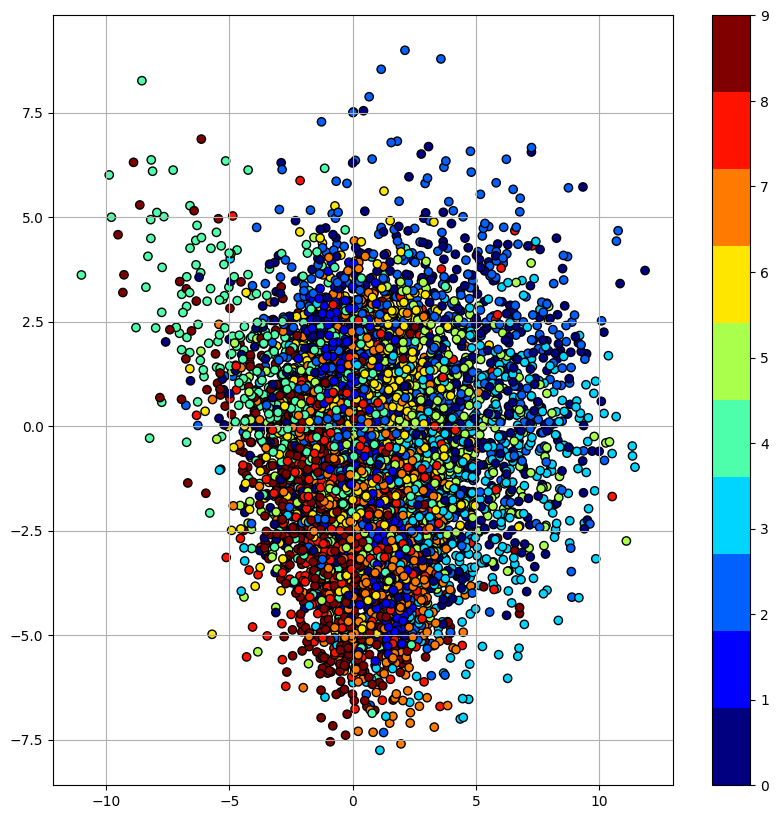

In [9]:
with torch.no_grad():
    model = trainer.model
    model.eval()
    z=[];label=[]
    for x,y in trainer.val_loader:

        z_ = model.encoder(x.to(trainer.device))
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from autoencoder_starter import scatter_plot
print(z.shape)
z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(z)
print(z_embedded.shape)
scatter_plot(latent_representations=z,labels=label)

(10000, 30)
(10000, 2)


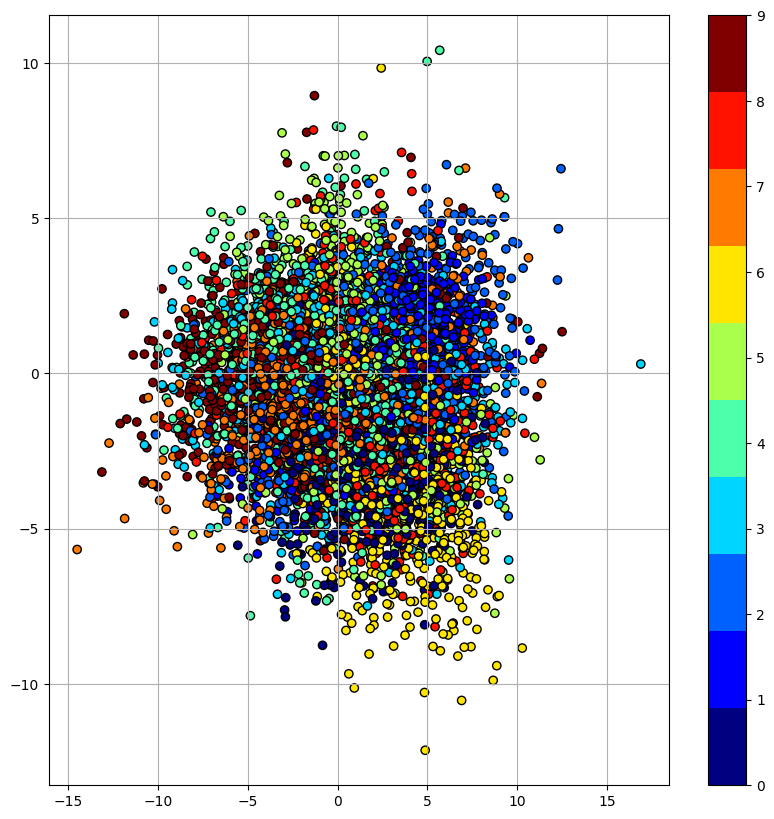

In [11]:
######## VAE model #########

with torch.no_grad():
    model = vae_trainer.model
    model.eval()
    z=[];label=[]
    for x,y in vae_trainer.val_loader:

        mean, logvar = model.encoder(x.to(vae_trainer.device))
        z_ = model.reparameterise(mean, logvar)
        z += z_.cpu().tolist()
        label += y.cpu().tolist()
    z = np.asarray(z)
    label = np.asarray(label)

from VAE_starter import scatter_plot
print(z.shape)
z_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(z)
print(z_embedded.shape)
scatter_plot(latent_representations=z,labels=label)

## Generating Images by Sampling Bottleneck Features

So here we can generate new images by sampling bottleneck features, and use the decoder to generate images. 

The code below provides an example of how to generate images by sampling bottleneck features. 

The `display_images_in_a_row` takes the following arguments:
* images: (N,28,28): N images of 28*28 as a numpy array
* file_path: file path name for where to store the figure
* display: display the image or not


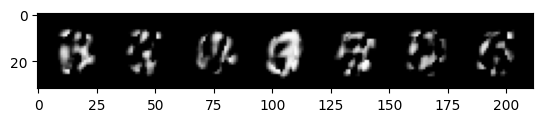

In [12]:
with torch.no_grad():
    samples = torch.randn(7, 30).to(trainer.device)
    samples = trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

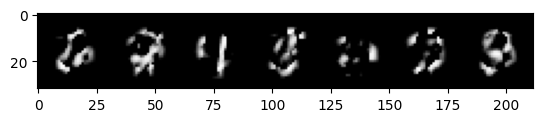

In [15]:
with torch.no_grad():
    samples = torch.randn(7, 30).to(vae_trainer.device)
    samples = vae_trainer.model.decoder(samples).cpu()

images = samples

from autoencoder_starter import display_images_in_a_row
display_images_in_a_row(images)

## Reconstructing Images

We can first retrieve the validation set and then pick 64 images (the first 64 images, though you can do it randomly).

We use the autoencoder to reconstruct the images and visualize them below.

Original images


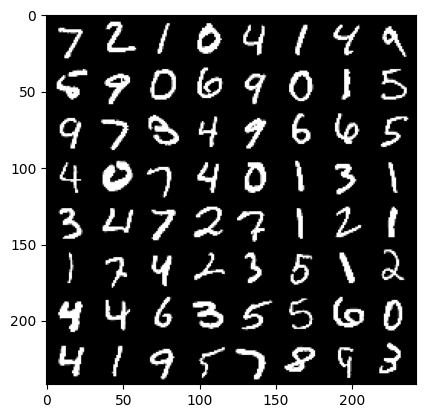

In [16]:
images = trainer.get_val_set() # get the entire validation set
total_number = 64
images = images[:total_number]

from autoencoder_starter import display_images_in_a_row
print("Original images")
display_images_in_a_row(images.cpu())

Reconstructed images


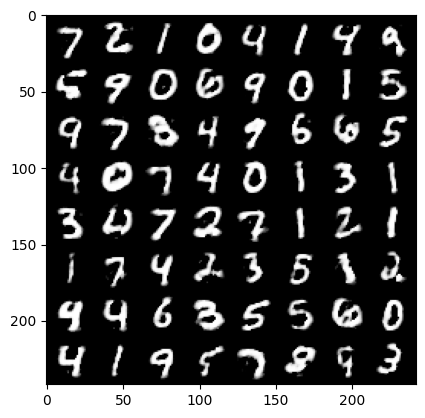

In [17]:
with torch.no_grad():
    images = images.to(trainer.device)
    reconstructed = trainer.model(images).cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)

Reconstructed images


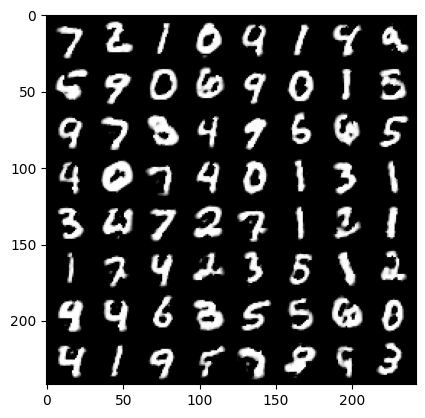

In [18]:
with torch.no_grad():
    images = images.to(vae_trainer.device)
    reconstructed = vae_trainer.model(images).cpu()
print("Reconstructed images")
display_images_in_a_row(reconstructed)